In [1]:
import sys
print(sys.version)

3.6.3 |Anaconda custom (64-bit)| (default, Nov  8 2017, 18:10:31) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [2]:
sys.version_info

sys.version_info(major=3, minor=6, micro=3, releaselevel='final', serial=0)

In [3]:
import sympy
sympy.__version__

'1.1.1'

In [4]:
from sympy import *
init_printing()

The next cell implements a `class FE(Lambda)` similar to the definition in `fun_expr.Function_from_Expression`.

I had expected there is no need to define a `__new__()` method for `class FE(Lambda)`. But something goes wrong and i can not figure out, what it is. If line 5 in the next cell 

`return super().__new__(cls, variables, expr)`

is commented, the `__new__()` method of `FE` is defined and everything works as expected, but

`FE(x,x)`

is not the IdentitiyFunction anymore. Line 5 of the next cell is a shortcut to `Lambda.__new__()`. Alternatively to uncomment this line, the whole method `FE.__new__()` could be commented. Then

`FE(x,x)` 

results in the IdentityFunction, but is no more of class `FE` with the result, that i.e.

`FE(x,x).diff(x) == 0` 

holds true. Somehow -i have no clue, how- the inheritance hierarchy is broken. Maybe the problem is, that

`sympy.functions.elementary.miscellaneous.IdentityFunction`

inherits from `Lambda`.

In [5]:
class FE(Lambda):
    def __new__(cls, variables, expr):
        # shortcut:
        # comment the next line and everything works
        return super().__new__(cls, variables, expr)
        """
        Create the body of the function.
        
        __new__ must be redefined in order to avoid to
        return the IdentityFunction. The IdentityFunction is 
        not of type FE, so there are no methods of this class
        available.
        """
        
        # see source of Lambda for the next lines
        from sympy.utilities.iterables import iterable
        v = list(variables) if iterable(variables) else [variables]
        for i in v:
            if not getattr(i, 'is_Symbol', False):
                raise TypeError('variable is not a symbol: %s' % i)

        obj = Expr.__new__(cls, Tuple(*v), sympify(expr))
        obj.nargs = FiniteSet(len(v))
        return obj
    
    
    def diff(self, *symbols, **assumptions):
        """
        Differentiate function.
        
        Returns a function with the variables of this function
        and the differentiated expression.
        
        If as_function=False then return differentiated expression
        
        Example:
        >>> from sympy import *
        >>> a,x = symbols('a,x')
        >>> f = FE(x, a*x**2)
        >>> f.diff() # returns error
        >>> f.diff(x)
        ((x) \mapsto 2*a*x)
        >>> f.diff(x, as_function = False)
        2*a*x
        """
        as_function = assumptions.pop('as_function',True)
        expr = self.expr.diff(*symbols, **assumptions)
        if as_function:
            return FE(self.variables, expr)
        return expr
    
    def integrate(self, *args, **kwargs):
        """
        integrate returns the result as expression
        
        If as_function=True return result as function
        of the remaining variables. If no variables are left,
        raise TypeError('no variable left to define a function')
        
        Example:
        >>> from sympy import *
        >>> from myfunction import Function_from_Expression as FE
        >>> a,x = symbols('a,x')
        >>> f = FE(x, a*x**2)
        >>> f.integrate(x)
        a*x**3/3
        >>> x_0, x_1 = symbols('x_0,x_1')
        >>> f.integrate((x,x_0,x_1))
        -a*x_0**3/3 + a*x_1**3/3
        >>> f.integrate(x,as_function=True)
        ((x) \mapsto a*x**3/3)
        >>> f.integrate((x,1,2), as_function=True) # raises TypeError
        """
        as_function = kwargs.pop('as_function', False)
        expr = self.expr.integrate(*args, **kwargs)
        
        if as_function:
            free_symbols = expr.free_symbols
            new_variables = tuple(v for v in self.variables if v in free_symbols)
            if new_variables:
                return FE(new_variables, expr)
            else:
                raise TypeError('no variable left to define a function')
        
        return expr



In [6]:
x = Symbol('x')
f = FE(x, x**2)
f

In [7]:
f.is_Function

True

In [8]:
f_1 = f.diff(x)
f_1

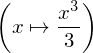

In [9]:
e = f.integrate(x, as_function=True)
e

In [10]:
g = FE(x,x)
g

In [11]:
type(g)

sympy.functions.elementary.miscellaneous.IdentityFunction

In [12]:
g.is_Function

True

In [13]:
isinstance(g,FE)

False

In [14]:
isinstance(g,Lambda)

True

In [15]:
isinstance(g,sympy.functions.elementary.miscellaneous.IdentityFunction)

True

In [16]:
# wrong:
g_1 = g.diff(x)
g_1

In [17]:
g.variables

In [18]:
g.expr

In [19]:
g(x).diff(x)

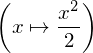

In [20]:
h = FE(x, x**2/2)
h

In [21]:
isinstance(h,FE)

True

In [22]:
isinstance(h.diff(x),FE)

False

In [23]:
isinstance(h.diff(x),Lambda)

True

In [24]:
# wrong
h.diff(x).diff(x)

In [25]:
# correct
h.diff(x,2)

In [26]:
# weird
h.diff(x)(x).diff(x)